In [337]:
# -------------------------------
# Importing necessary libraries
# -------------------------------

# "datasets" library from Hugging Face to load pre-built datasets
from datasets import load_dataset

# Scikit-learn tools for splitting the data and scaling features
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import VarianceThreshold

# Imbalanced-learn method to handle imbalanced datasets
from imblearn.combine import SMOTEENN

# Import the seaborn library for advanced statistical visualizations
import seaborn as sns

# Import matplotlib.pyplot for creating and customizing plots
import matplotlib.pyplot as plt

# Import NumPy for arrays, matrices, and mathematical operations
import numpy as np

# Pandas for data manipulation and analysis
import pandas as pd

In [338]:
# -------------------------------
# Load the dataset and convert to Pandas DataFrame
# -------------------------------

# Load the fraud detection dataset from Hugging Face
dataset = load_dataset("CiferAI/Cifer-Fraud-Detection-Dataset-AF")

# Convert the training split of the dataset to a Pandas DataFrame for easier manipulation
df = dataset["train"].to_pandas()
df = df.sample(100000, random_state=42)

# Convert columns to the best possible dtypes (e.g., int64 → Int64, object → string)
# This helps prevent potential type issues and ensures consistent data types
df = df.convert_dtypes()

In [339]:
# -------------------------------
# Explore basic information about the dataset
# -------------------------------

# Display the first 5 rows to get an overview of the data
print("First 5 rows of the dataset:")
display(df.head())

First 5 rows of the dataset:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
9811966,147,CASH_IN,329822.99,sdv-pii-1hybr,4806431.42,5947257.03,sdv-pii-a89t7,419530.31,3697373.7,0,0
3361606,450,PAYMENT,20295.13,C1114778583,0.01,499.17,C689793442,4467189.32,1290654.24,0,0
12871380,57,CASH_OUT,32781.69,sdv-pii-suuas,143.37,20.69,sdv-pii-k2ai2,1129675.95,4979770.75,0,0
20899941,210,CASH_OUT,94808.87,C1629867471,974.7,32834.22,C350001556,526137.5,3.11,0,0
4740903,362,CASH_OUT,84063.92,C1758188565,192732.65,417339.55,M1856647425,1131265.84,4833.99,0,0


In [340]:
# Display the shape of the DataFrame (number of rows and columns)
print(f"Dataset shape: {df.shape[0]} rows x {df.shape[1]} columns")

Dataset shape: 100000 rows x 11 columns


In [341]:
# Display the data types of each column in a readable table
print("Column data types:")
print(df.dtypes.to_frame(name="Data Type"))

Column data types:
                     Data Type
step                     Int64
type            string[python]
amount                 Float64
nameOrig        string[python]
oldbalanceOrg          Float64
newbalanceOrig         Float64
nameDest        string[python]
oldbalanceDest         Float64
newbalanceDest         Float64
isFraud                  Int64
isFlaggedFraud           Int64


In [342]:
# Display descriptive statistics for all columns
# - include="all" ensures statistics are shown for both numerical and categorical columns
# - Transposed (.T) for easier reading, with columns as rows
print("Descriptive statistics for all columns:")
display(df.describe(include="all").T)

Descriptive statistics for all columns:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
step,100000.0,<NA>,<NA>,<NA>,239.05161,163.31829,1.0,112.0,205.0,333.0,743.0
type,100000,5,CASH_OUT,35168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,100000.0,<NA>,<NA>,<NA>,180096.725553,254300.002848,0.0,18535.92,82439.97,237089.3325,3372884.25
nameOrig,100000,99588,C2004067929,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceOrg,100000.0,<NA>,<NA>,<NA>,1333776.646205,2563276.271045,0.01,10847.67,214436.5,1417799.2675,35750887.76
newbalanceOrig,100000.0,<NA>,<NA>,<NA>,2085442.678308,3418472.765839,0.0,58530.675,587468.685,2583263.93,35606731.6
nameDest,100000,95798,C1577420620,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceDest,100000.0,<NA>,<NA>,<NA>,1931896.31965,2502406.136687,0.02,275196.1625,1013925.075,2611518.7025,35288865.77
newbalanceDest,100000.0,<NA>,<NA>,<NA>,3747153.978052,10407941.68242,0.0,100.03,65362.62,1998865.42,198182360.57
isFraud,100000.0,<NA>,<NA>,<NA>,0.00129,0.035894,0.0,0.0,0.0,0.0,1.0


In [343]:
# Check for missing values across the entire dataset
total_missing = df.isna().sum().sum()
print(f"Total missing values in the dataset: {total_missing}")

Total missing values in the dataset: 0


In [344]:
# Check for duplicated rows in the dataset
total_duplicates = df.duplicated().sum()
print(f"Total duplicated rows in the dataset: {total_duplicates}")

Total duplicated rows in the dataset: 0


In [345]:
# Select all numeric columns in the DataFrame (integers and floats)
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
num_cols = [col for col in num_cols if df[col].nunique() > 5]

# Create an empty dictionary to store outliers for each column
outliers_dict = {}

# Loop through each numeric column to detect outliers
for col in num_cols:
    # Calculate the first quartile (25th percentile)
    Q1 = df[col].quantile(0.25)
    # Calculate the third quartile (75th percentile)
    Q3 = df[col].quantile(0.75)
    # Compute the interquartile range (IQR)
    IQR = Q3 - Q1
    # Identify outliers: values below Q1 - 3*IQR or above Q3 + 3*IQR
    outliers = df[(df[col] < Q1 - 3*IQR) | (df[col] > Q3 + 3*IQR)]
    # Store the outliers in the dictionary under the column name
    outliers_dict[col] = outliers[col]

# Print the number of outliers for each numeric column
for col, out in outliers_dict.items():
    print(f"{col} : {len(out)} outliers")

step : 0 outliers
amount : 2617 outliers
oldbalanceOrg : 6548 outliers
newbalanceOrig : 4160 outliers
oldbalanceDest : 1977 outliers
newbalanceDest : 12686 outliers


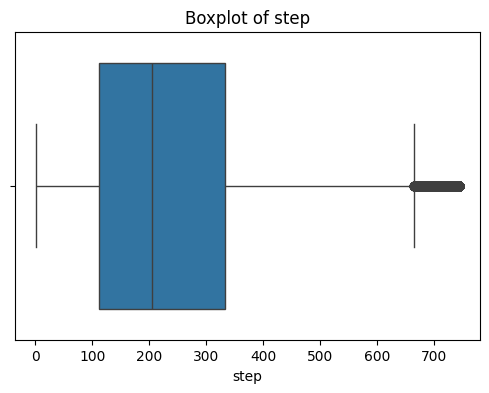

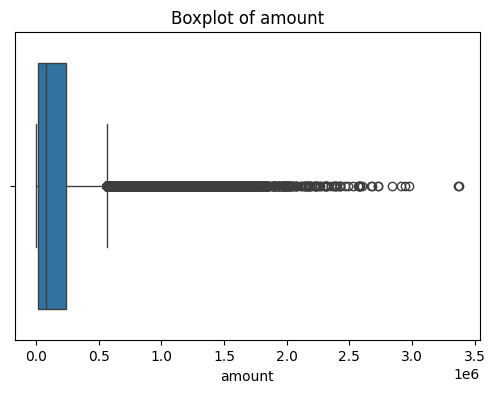

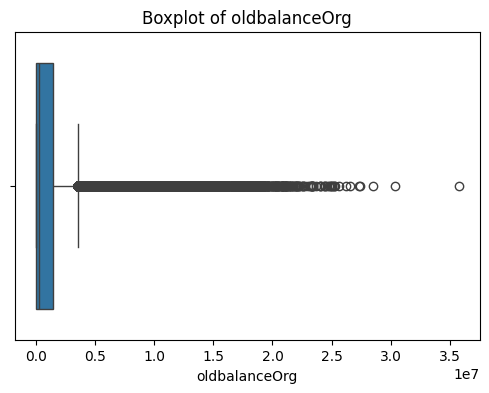

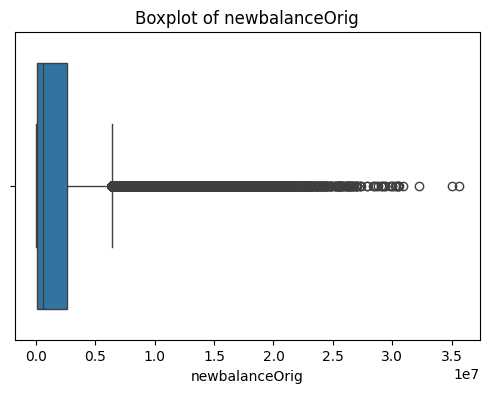

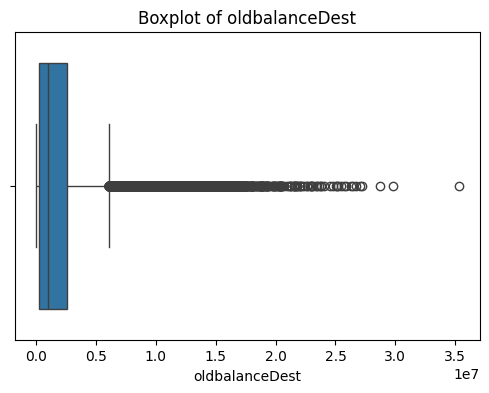

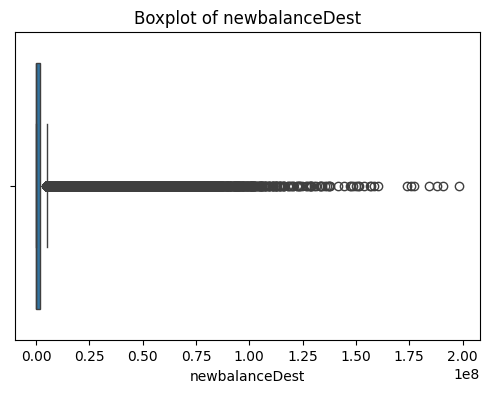

In [346]:
# Loop through each numeric column in the DataFrame
for col in num_cols:
    # Create a new figure with a specific size for better visibility
    plt.figure(figsize=(6, 4))
    
    # Draw a boxplot for the current column
    # The box shows the quartiles and median
    # Points outside the whiskers are considered outliers
    sns.boxplot(x=df[col])
    
    # Add a title to the plot indicating which column it represents
    plt.title(f'Boxplot of {col}')
    
    # Label the x-axis with the column name
    plt.xlabel(col)
    
    # Display the plot
    plt.show()

Since the dataset we are using is fully synthetic, generated from real data, there are no typos or other human errors. Human mistakes are usually the main cause of outliers. Therefore, we will not remove outliers during preprocessing, as doing so could eliminate data that might be important for our model.

In [347]:
# -----------------------------------------------------------------------
# BALANCE-BASED FEATURES
# -----------------------------------------------------------------------

# delta_balance_sender :
# This measures how much money the sender's balance decreased after the transaction.
# In a normal transaction, newbalanceOrig = oldbalanceOrg - amount.
# If this difference does not match the transaction amount, there is an inconsistency.
df["delta_balance_sender"] = df["oldbalanceOrg"] - df["newbalanceOrig"]

# delta_balance_recipient :
# This measures how much the recipient's balance increased after receiving money.
# Normally: newbalanceDest = oldbalanceDest + amount.
# Large or inconsistent changes may indicate suspicious activity.
df["delta_balance_recipient"] = df["newbalanceDest"] - df["oldbalanceDest"]

# abs_delta_sender / abs_delta_recipient :
# The absolute size of balance variations for sender and recipient.
# Large absolute changes tend to occur in suspicious transactions.
df["abs_delta_sender"] = df["delta_balance_sender"].abs()
df["abs_delta_recipient"] = df["delta_balance_recipient"].abs()

# amount_over_oldbalance :
# Ratio comparing the transaction value to the sender's previous balance.
# If this ratio is close to 1, the sender empties almost all their funds → red flag.
df["amount_over_oldbalance"] = df["amount"] / (df["oldbalanceOrg"] + 1)

# amount_over_newbalance :
# Ratio comparing the amount to the sender's remaining balance after the transaction.
# A high value suggests a sudden drop in available funds.
df["amount_over_newbalance"] = df["amount"] / (df["newbalanceOrig"] + 1)

# amount_over_total_balance :
# Ratio comparing the amount to the combined balances of sender and recipient.
# Helps detect disproportionate transfers relative to account wealth.
df["amount_over_total_balance"] = df["amount"] / (df["oldbalanceOrg"] + df["oldbalanceDest"] + 1)

# delta_balance_net :
# Measures the total net change across both accounts.
# For a normal transaction, sender decrease + recipient increase = amount.
# Deviations from this expected pattern often indicate fraud or synthetic data issues.
df["delta_balance_net"] = (df["newbalanceOrig"] - df["oldbalanceOrg"]) + \
                          (df["newbalanceDest"] - df["oldbalanceDest"])

# -----------------------------------------------------------------------
# TYPE-BASED ENCODING
# -----------------------------------------------------------------------

# fraud_rate_per_type :
# Fraud probability of each transaction type (e.g., TRANSFER, CASH_OUT).
# Some types are statistically more fraudulent than others.
fraud_rate_per_type = df.groupby("type")["isFraud"].mean()

# type_encoded :
# Each transaction receives the average fraud risk of its type.
# This captures "some transaction types are riskier than others".
df["type_encoded"] = df["type"].map(fraud_rate_per_type)

# type_times_amount :
# Interaction between transaction type and amount.
# Large amounts in high-risk transaction types raise suspicion dramatically.
df["type_times_amount"] = df["type_encoded"] * df["amount"]

# -----------------------------------------------------------------------
# FLAG / THRESHOLD FEATURES
# -----------------------------------------------------------------------

# high_amount_flag :
# Only equals the transaction amount if "isFlaggedFraud" is triggered.
# This emphasizes very large transactions.
df["high_amount_flag"] = df["isFlaggedFraud"] * df["amount"]

# large_tx :
# Binary indicator: 1 if amount > 50% of sender’s balance.
# Fraudsters often drain accounts quickly.
df["large_tx"] = (df["amount"] > 0.5 * df["oldbalanceOrg"]).astype(int)

# -----------------------------------------------------------------------
# TEMPORAL FEATURES
# -----------------------------------------------------------------------

# hour and day :
# Extract time-of-day and day-of-simulation from the "step" variable.
# Fraud often spikes at night or weekends when monitoring is lighter.
df["hour"] = df["step"] % 24
df["day"] = df["step"] // 24

# is_weekend :
# 1 if transaction occurs on Saturday or Sunday.
df["is_weekend"] = (df["day"] % 7).isin([5, 6]).astype(int)

# is_night :
# 1 if transaction occurs at night (22h → 6h).
# Most fraud attempts happen outside business hours.
df["is_night"] = df["hour"].between(22, 6).astype(int)

# -----------------------------------------------------------------------
# RECIPIENT-RELATED FEATURES
# -----------------------------------------------------------------------

# sender_receiver_same :
# 1 if sender and receiver IDs are identical.
# Rare and suspicious case; useful for detecting synthetic transactions.
df["sender_receiver_same"] = (df["nameOrig"] == df["nameDest"]).astype(int)

# -----------------------------------------------------------------------
# BEHAVIORAL RATIO FEATURES
# -----------------------------------------------------------------------

# amount_over_mean_sender :
# Compare the current amount to sender's average transaction amount.
# Fraud often shows amounts that are unusually high for the account’s history.
df["amount_over_mean_sender"] = df["amount"] / \
    (df.groupby("nameOrig")["amount"].transform("mean") + 1)

# -----------------------------------------------------------------------
# INTERACTION FEATURES
# -----------------------------------------------------------------------

# type_flag_amount :
# Combines:
# - the risk level of the transaction type,
# - the flagged indicator,
# - and the amount.
# This feature sharply increases in likely-fraudulent transactions.
df["type_flag_amount"] = df["type_encoded"] * df["isFlaggedFraud"] * df["amount"]

# delta_sender_over_recipient :
# Compares how much the sender balance decreases vs. how much the recipient balance increases.
# In a perfect transaction, this ratio should be ~1.
# Deviations reveal inconsistencies characteristic of fraud.
df["delta_sender_over_recipient"] = df["delta_balance_sender"] / \
                                    (df["delta_balance_recipient"] + 1)

# -----------------------------------------------------------------------
# SENDER ACTIVITY FEATURES
# -----------------------------------------------------------------------

# sender_tx_count :
# Number of transactions previously made by the sender.
# Fraudulent accounts typically have abnormally low activity (new accounts)
# or abnormally high activity (bot-driven fraud).
df["sender_tx_count"] = df.groupby("nameOrig")["amount"].transform("count")

# sender_total_amount :
# Total amount historically transferred by this sender.
# Fraudsters often attempt a few very large withdrawals, creating anomalies.
df["sender_total_amount"] = df.groupby("nameOrig")["amount"].transform("sum")

# sender_max_amount :
# Maximum amount ever sent by this sender.
# Used to detect if the current transaction is unusually large.
df["sender_max_amount"] = df.groupby("nameOrig")["amount"].transform("max")

# amount_over_sender_max :
# Ratio: current amount / sender’s historical maximum.
# If this ratio > 1, the current transaction is the biggest ever,
# which strongly increases suspicion.
df["amount_over_sender_max"] = df["amount"] / (df.groupby("nameOrig")["amount"].transform("max") + 1)

# -----------------------------------------------------------------------
# RECIPIENT ACTIVITY FEATURES
# -----------------------------------------------------------------------

# recipient_tx_count :
# Number of transactions received by the recipient.
# Fraudsters sometimes redirect stolen funds into a “collector” account
# that receives many transfers.
df["recipient_tx_count"] = df.groupby("nameDest")["amount"].transform("count")

# recipient_total_received :
# Total amount historically received by this recipient.
# A sudden large incoming transfer to a low-activity (“fresh”) recipient
# is usually suspicious.
df["recipient_total_received"] = df.groupby("nameDest")["amount"].transform("sum")

# recipient_heavy_receiver :
# Binary indicator marking recipients who receive an unusually high number of transfers.
# Identifies “mule” accounts used to collect money before laundering.
df["recipient_heavy_receiver"] = (df["recipient_tx_count"] > df["recipient_tx_count"].median()).astype(int)

# -----------------------------------------------------------------------
# BALANCE CONSISTENCY CHECKS
# -----------------------------------------------------------------------

# balance_sender_error :
# For a legitimate transaction:
# newbalanceOrig should equal oldbalanceOrg - amount.
# This feature measures how far the actual transaction deviates from that rule.
# Fraudulent or synthetic transactions often violate balance logic.
df["balance_sender_error"] = (df["oldbalanceOrg"] - df["amount"]) - df["newbalanceOrig"]

# abs_balance_sender_error :
# Absolute deviation from expected sender balance.
# The larger the value, the more suspicious the transaction.
df["abs_balance_sender_error"] = df["balance_sender_error"].abs()

# balance_recipient_error :
# For a normal transfer:
# newbalanceDest should equal oldbalanceDest + amount.
# This feature quantifies inconsistencies for the recipient.
df["balance_recipient_error"] = (df["oldbalanceDest"] + df["amount"]) - df["newbalanceDest"]

# abs_balance_recipient_error :
# Absolute form of the above.
# Large values are strong indicators of fraudulent or buggy data.
df["abs_balance_recipient_error"] = df["balance_recipient_error"].abs()

# balance_error_total :
# Sum of sender and recipient inconsistencies.
# Helps measure global transaction invalidity.
df["balance_error_total"] = df["abs_balance_sender_error"] + df["abs_balance_recipient_error"]

# -----------------------------------------------------------------------
# AMOUNT / BALANCE RELATIONSHIPS
# -----------------------------------------------------------------------

# amount_over_net_balance :
# Ratio of the transaction amount to the combined post-transaction balances
# of both accounts.
# Fraudulent transfers often represent unusually high proportions of account funds.
df["amount_over_net_balance"] = df["amount"] / (df["newbalanceOrig"] + df["newbalanceDest"] + 1)

# -----------------------------------------------------------------------
# TYPE INDICATORS
# -----------------------------------------------------------------------

# is_cash :
# Marks transactions that are CASH_IN or CASH_OUT.
# These operations are statistically high-risk because cash movements are harder to trace.
df["is_cash"] = df["type"].isin(["CASH_OUT", "CASH_IN"]).astype(int)

# is_transfer :
# Marks TRANSFER operations only.
# In the dataset, almost all fraudulent events are TRANSFER or CASH_OUT,
# so this indicator is useful for models.
df["is_transfer"] = df["type"].isin(["TRANSFER"]).astype(int)

# -----------------------------------------------------------------------
# TEMPORAL BEHAVIOR FEATURES
# -----------------------------------------------------------------------

# First, sort transactions chronologically for each sender.
# This ensures temporal features reflect the true sequence of events.
df = df.sort_values(by=["nameOrig", "step"]).reset_index(drop=True)

# time_since_last_tx :
# Time (in hours) since the sender’s previous transaction.
# Fraudsters often make many rapid attempts in short time windows.
# Normal users show stable, regular interval patterns.
df["time_since_last_tx"] = df.groupby("nameOrig")["step"].diff().fillna(-1)

# time_until_next_tx :
# Time until the next transaction (symmetric measure).
# Very tight clusters (e.g., 3 transactions in 10 minutes) often indicate fraud.
df["time_until_next_tx"] = df.groupby("nameOrig")["step"].diff(-1).abs().fillna(-1)

# mean_time_between_tx :
# Sender’s typical transaction spacing.
# Allows us to quantify how "normal" the current timing is for this account.
# Fraudsters who hijack an account usually break the established rhythm.
df["mean_time_between_tx"] = df.groupby("nameOrig")["time_since_last_tx"] \
                               .transform(lambda x: x[x >= 0].mean())

# time_gap_deviation :
# Difference between actual and typical transaction spacing.
# Large positive or negative deviations signal unusual timing behavior.
df["time_gap_deviation"] = (
    df["time_since_last_tx"] - df["mean_time_between_tx"]
)

In [348]:
# -------------------------------
# One-Hot Encoding and Feature Cleanup
# -------------------------------

# Apply one-hot encoding to the "type" column
# - Each transaction type becomes a separate binary column
# - drop_first=False keeps all categories (useful if no baseline is needed)
df = pd.get_dummies(df, columns=["type"], drop_first=False)

# Drop identifier columns that are not useful for modeling
# - "nameOrig" and "nameDest" are anonymized IDs and not predictive
df.drop(columns=["nameDest", "nameOrig"], inplace=True)

# Keep only the numerical columns in the DataFrame, since correlation analysis
# requires numeric data. Then convert all these columns to standard float dtype.
# This ensures that any Pandas extension types (e.g., Int64, Float64 with pd.NA)
# are converted into regular float columns where missing values become np.nan.
df = df.select_dtypes(include=["number"]).astype(float)

In [349]:
# -------------------------------
# Correlation Analysis with the target variable
# -------------------------------

# Compute correlation of all features with "isFraud"
# - Sorted by absolute correlation to highlight the most informative features
corr_with_fraud = df.corr()[["isFraud"]].sort_values(
    by="isFraud",
    key=abs,       # Sort by absolute value
    ascending=False
)
print("Correlation of Features with isFraud:")
print(corr_with_fraud)

Correlation of Features with isFraud:
                              isFraud
isFraud                      1.000000
type_encoded                 0.009047
abs_balance_sender_error    -0.005802
is_transfer                 -0.005763
abs_delta_sender            -0.005391
balance_sender_error         0.004907
recipient_total_received    -0.004822
sender_total_amount         -0.004660
is_cash                      0.004630
sender_max_amount           -0.004604
amount                      -0.004480
delta_balance_sender         0.004447
day                          0.003463
amount_over_oldbalance      -0.003411
step                         0.003373
balance_error_total         -0.003280
sender_tx_count             -0.003276
delta_balance_net           -0.002934
newbalanceOrig              -0.002913
type_times_amount           -0.002877
amount_over_mean_sender     -0.002822
amount_over_newbalance      -0.002581
large_tx                    -0.002044
oldbalanceDest               0.001977
hour        

In [350]:
# -------------------------------------------------------------
# Variance-based feature removal
# -------------------------------------------------------------
# The objective of this section is to remove features that contain
# very little variation in their values. Such features do not help
# a model learn meaningful patterns and often increase noise.

# Some features should NOT be removed even if their variance is low.
# For example:
# - binary features (0/1)
# - small discrete sets (e.g., day of week, hour of day)
protected_columns = [
    col for col in df.columns
    if df[col].nunique() < 6
]

# All columns except the protected ones are given to VarianceThreshold.
columns_for_variance = [
    col for col in df.columns
    if col not in protected_columns
]

# threshold=0.01 means:
# "Remove features whose variance is less than 1%".
selector = VarianceThreshold(threshold=0.01)

# Fit the selector on the subset of columns to analyze
selector.fit(df[columns_for_variance])

# Extract the columns that passed the variance filter
kept_columns_after_variance = df[columns_for_variance].columns[
    selector.get_support()
]

# Combine protected features + features with enough variance
final_columns = list(protected_columns) + list(kept_columns_after_variance)

# Identify columns to drop (low-variance AND not protected)
columns_to_drop = [
    col for col in columns_for_variance
    if col not in kept_columns_after_variance
]

print("Columns dropped due to low variance:")
for col in columns_to_drop:
    print(f"  - {col}")

# Drop low-variance columns from the dataframe
df.drop(columns=columns_to_drop, inplace=True)

Columns dropped due to low variance:
  - amount_over_mean_sender
  - amount_over_sender_max


This code is used to quickly estimate the importance of each feature in the dataset for predicting fraud, without training a full-scale model on the entire dataset.
1. Sampling: Only 10% of the training data is selected (X_sample and y_sample) to reduce computation time while still capturing useful patterns.
2. ExtraTreesClassifier: This ensemble method is chosen because it is fast, robust, and can handle many features. It aggregates multiple randomized decision trees to estimate feature importance.
3. Feature importance extraction: After fitting the classifier on the sampled data, feature_importances_ provides a quantitative measure of how informative each feature is for predicting fraud.
4. Ranking features: Sorting the importance values helps identify the top features that contribute most to fraud detection, which can guide feature selection or further analysis.

Overall, this approach allows you to prioritize features and gain insights into which variables are most relevant before committing to a full model training, saving both time and computational resources.

<Figure size 1200x2100 with 0 Axes>

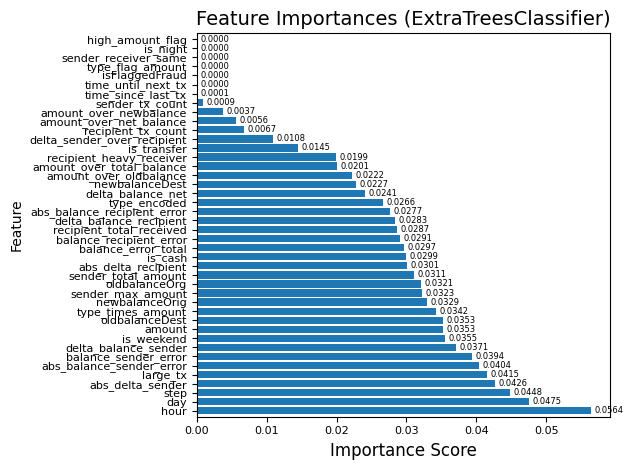

Selected 17 features above importance threshold 0.03
['hour', 'day', 'step', 'abs_delta_sender', 'large_tx', 'abs_balance_sender_error', 'balance_sender_error', 'delta_balance_sender', 'is_weekend', 'amount', 'oldbalanceDest', 'type_times_amount', 'newbalanceOrig', 'sender_max_amount', 'oldbalanceOrg', 'sender_total_amount', 'abs_delta_recipient']


In [351]:
# -------------------------------------------------------------
# Feature importance estimation using ExtraTreesClassifier
# -------------------------------------------------------------
# ExtraTrees is a very fast tree-based ensemble method that provides
# reliable feature importance ranking. It is much faster than
# RandomForest and works well even on large tabular datasets.

# Separate features and target
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

# Clip extremely large values to avoid numerical overflow
X = X.clip(-1e10, 1e10)

# Subsample the dataset for efficiency
# Training ExtraTrees on very large datasets can require several minutes.
# Using a 10% random sample provides an accurate approximation while
# dramatically reducing computation time.
sample_size = int(0.10 * len(X))  # Use 10% of the dataset
X_sample = X.sample(sample_size, random_state=42)
y_sample = y.loc[X_sample.index]  # Match target labels to sampled rows

# If still too large, further reduce to a maximum of 500,000 samples
if len(X_sample) > 500_000:
    X_sample, _, y_sample, _ = train_test_split(
        X_sample,
        y_sample,
        train_size=500_000,
        stratify=y_sample,
        random_state=42
    )

# Train the ExtraTrees model
# class_weight="balanced" is very important for fraud detection,
# because the dataset is extremely imbalanced (far more legitimate
# transactions than fraudulent ones).
model = ExtraTreesClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

model.fit(X_sample, y_sample)

# Extract and sort feature importances
importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(12, max(15, len(importance_df) * 0.50)))

ax = importance_df.plot(
    x="feature",
    y="importance",
    kind="barh",
    fontsize=8,
    legend=False,
    width=0.8
)

plt.title("Feature Importances (ExtraTreesClassifier)", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=10)

# Add textual annotation of importance values next to bars
for i, importance_value in enumerate(importance_df["importance"]):
    ax.text(
        importance_value + 0.0005,
        i,
        f"{importance_value:.4f}",
        fontsize=6,
        va="center"
    )

plt.tight_layout()
plt.show()

# Select features using an importance threshold
importance_threshold = 0.03  # Features below this importance are removed

selected_features = importance_df[
    importance_df["importance"] >= importance_threshold
]["feature"].tolist()

print(f"Selected {len(selected_features)} features above importance threshold {importance_threshold}")
print(selected_features)

# Create reduced dataset including only selected features + target
df = df[selected_features + ["isFraud"]]

Principal Component Analysis (PCA) was not used in this project for several reasons. First, the dataset contains features that have meaningful real-world interpretations, such as transaction amounts, balances and frequency-related variables. Applying PCA would transform these features into abstract linear combinations that are harder to interpret, which reduces the explainability of the fraud detection model.

Second, PCA is mostly beneficial when the feature space is very high-dimensional or highly correlated. In this dataset, the number of features is relatively small and manageable, and the correlations do not justify a dimensionality reduction step. As a result, PCA would add unnecessary complexity without providing substantial performance gains.

Finally, many machine learning models used in fraud detection (such as tree-based algorithms) do not require standardized or orthogonal features and are already robust to correlated variables. Therefore, PCA would not significantly improve model performance and might even degrade it by removing information relevant for classification.

For these reasons, PCA was intentionally not applied in the preprocessing pipeline.

In [352]:
# -----------------------------------------------------------
# Separate features (X) and target label (y)
# -----------------------------------------------------------

X = df.drop("isFraud", axis=1)
y = df["isFraud"]

# -----------------------------------------------------------
# Clip extreme numeric values to avoid instability during scaling
# This prevents numerical overflow issues.
# -----------------------------------------------------------

X = X.clip(-1e10, 1e10)

In [353]:
# -----------------------------------------------------------
# Split (80% train, 20% test) while preserving class distribution (stratification)
# -----------------------------------------------------------

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# -----------------------------------------------------------
# Further split training set into training (75%) and validation (25%)
# Validation is used for model tuning and early stopping.
# -----------------------------------------------------------

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

# -----------------------------------------------------------
# Standardize numerical features using RobustScaler
# Scaling helps models like logistic regression, SVM, and neural networks.
# -----------------------------------------------------------

scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [354]:
# -----------------------------------------------------------
# Apply SMOTEENN to handle class imbalance on the training set.
# SMOTEENN combines oversampling (SMOTE) and cleaning (ENN),
# improving minority class representation while removing noisy samples.
# -----------------------------------------------------------

smote_enn = SMOTEENN(random_state=42)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

In [355]:
# -----------------------------------------------------------
# Save datasets to Parquet format for efficient storage and fast loading.
# Parquet offers columnar storage and good compression.
# -----------------------------------------------------------

output_path = "./data/"

df.to_parquet(f"{output_path}df.parquet", index=False)
X_train.to_parquet(f"{output_path}X_train.parquet", index=False)
X_test.to_parquet(f"{output_path}X_test.parquet", index=False)
X_val.to_parquet(f"{output_path}X_val.parquet", index=False)
y_train.to_frame(name="isFraud").to_parquet(f"{output_path}y_train.parquet", index=False)
y_test.to_frame(name="isFraud").to_parquet(f"{output_path}y_test.parquet", index=False)
y_val.to_frame(name="isFraud").to_parquet(f"{output_path}y_val.parquet", index=False)

print(f"Train set : {len(X_train)} samples ({y_train.mean():.2%} fraud)")
print(f"Val set   : {len(X_val)} samples ({y_val.mean():.2%} fraud)")
print(f"Test set  : {len(X_test)} samples ({y_test.mean():.2%} fraud)")

Train set : 157366 samples (50.77% fraud)
Val set   : 10000 samples (0.13% fraud)
Test set  : 10000 samples (0.13% fraud)


#### Pistes d’exploration et travaux à poursuivre

Il reste plusieurs axes d’amélioration possibles pour aller plus loin dans l’analyse et la préparation des données. Voici une liste non exhaustive des prochaines étapes envisageables :
- Exécuter le script sur l’ensemble du dataset ; jusqu’à présent, tous les traitements ont été réalisés sur un échantillon, faute de puissance de calcul. L’exécution sur l’intégralité des données permettrait d’obtenir des résultats plus fiables.
- Réaliser des analyses statistiques avancées : ces tests n’ont pas encore été effectués, mais ils pourraient fournir des informations précieuses pour la sélection des features :
    - Information mutuelle (Mutual Information)
    - Tests ANOVA ou Chi²
    - Permutation Feature Importance
- Réduire le surapprentissage du modèle : le modèle a actuellement tendance à mémoriser les données d’entraînement. Une étude statistique plus approfondie permettrait d’identifier les colonnes réellement informatives et d’améliorer la généralisation.

Training baseline RandomForest model...

-------------------------------------------
Evaluation on: Training Set
-------------------------------------------
Accuracy:       0.8894
Precision:      0.8223
Recall:         0.9979
F1-score:       0.9016
ROC-AUC:        0.9841

Classification report:
              precision    recall  f1-score   support

         0.0     0.9972    0.7776    0.8738     77469
         1.0     0.8223    0.9979    0.9016     79897

    accuracy                         0.8894    157366
   macro avg     0.9097    0.8877    0.8877    157366
weighted avg     0.9084    0.8894    0.8879    157366



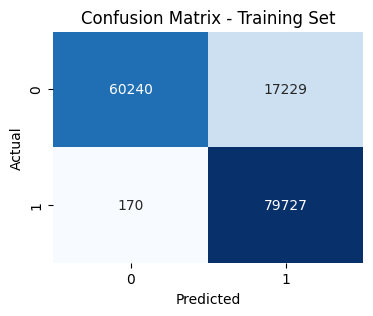


-------------------------------------------
Evaluation on: Test Set
-------------------------------------------
Accuracy:       0.7747
Precision:      0.0022
Recall:         0.3846
F1-score:       0.0044
ROC-AUC:        0.5729

Classification report:
              precision    recall  f1-score   support

         0.0     0.9990    0.7752    0.8730      9987
         1.0     0.0022    0.3846    0.0044        13

    accuracy                         0.7747     10000
   macro avg     0.5006    0.5799    0.4387     10000
weighted avg     0.9977    0.7747    0.8718     10000



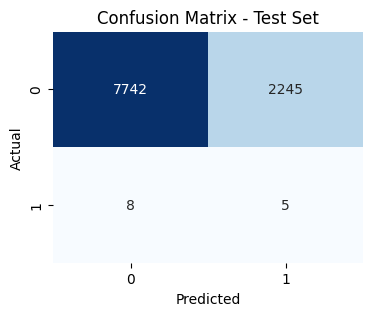

In [356]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Train a simple baseline model (Random Forest)
# ------------------------------------------------------------

print("Training baseline RandomForest model...")

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Train on the resampled training set (after SMOTE)
model.fit(X_train, y_train)

# ------------------------------------------------------------
# Evaluate on validation and test sets
# ------------------------------------------------------------

def evaluate_model(model, X, y, title="Dataset"):
    """Evaluate model performance on a given dataset."""
    preds = model.predict(X)
    proba = model.predict_proba(X)[:, 1]

    print("\n-------------------------------------------")
    print(f"Evaluation on: {title}")
    print("-------------------------------------------")
    print(f"Accuracy:       {accuracy_score(y, preds):.4f}")
    print(f"Precision:      {precision_score(y, preds):.4f}")
    print(f"Recall:         {recall_score(y, preds):.4f}")
    print(f"F1-score:       {f1_score(y, preds):.4f}")
    print(f"ROC-AUC:        {roc_auc_score(y, proba):.4f}")

    print("\nClassification report:")
    print(classification_report(y, preds, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y, preds)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


# ------------------------------------------------------------
# Run evaluation on training and test sets
# ------------------------------------------------------------

evaluate_model(model, X_train, y_train, title="Training Set")
evaluate_model(model, X_test, y_test, title="Test Set")